# Battery manufacturing costs example


The following notebook provides an example of the battery cost model. 

The price of the battery are determined ..

Battery manufacturing costs are calculated through both methods. 

Price vector methods for upstream materials.... 


Value added per process ($b$) is determined for each battery system.. 

In [2]:
#Import required packages
import numpy as np
import pandas as pd
import brightway2 as bw
import sys
import matplotlib.pyplot as plt

#Import the battery design module from a local path
local_path =r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model-1\batt_sust_model" #ADD PATH
sys.path.insert(1, local_path)
from battery_design import battery_design as bd
import battery_cost as bat_cost
import battery_emissions as bat_lca

#Local path to BatPaC version 5
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 - 8March2022.xlsm"#ADD PATH



## Calculate battery design
First, the material content of a single battery is obtained. The design of the Volkswagen ID.4. See also the battery design example notebook

In [3]:
#Establish battery system class of specific design:
battery = bd.Battery_system (    
                             vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)',                              
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             sep_film_thickness = 17,
                             negative_foil_thickness = 12,
                             positive_foil_thickness = 14,
                             positive_electrode_thickness = 87.3,
                             cells_in_parallel=3, #https://static.nhtsa.gov/odi/tsbs/2021/MC-10186407-0001.pdf
                             modules_in_parallel = 1,  
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range_miles =410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150 #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/auto       
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

In [4]:
# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background
bp_output = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=True)

## Calculate the factor requirement matrix ($\mathbf{F}$)

The factor requirements included are land/building area, capital equipment and labour.

The factor requirement matrix ($\mathbf{F}$) represents the factors (rows) and battery production processes (columns). 

Factor requirement ($F$) for all battery production process are based on the calculations of BatPaC as described in the BatPaC manual. Here factor requirements are adjusted to account for varying production volumes with the following equation:
$$F= F_b \left(\frac{P}{P_b}\right)^p$$

where $F_b$ refers to the baseline factor requirement matrix, $P$ to the modelled annual production process rate, $P_b$ to the base line process rate and $p$ is the scale factor. $F_b$, $P_b$ and $p$ are obtained from BatPaC.


The BatPaC calculations are used and converted to a Python model

In [5]:
#Convert BatPaC output to Brightway project parameter names 
result_dict = bat_lca.output_as_bw_param(bp_output)

# Append additional project parameters and recalculate project parameters (e.g. total anode active material based on process yield)
result_dict = {**bat_lca.get_project_parameters_dict(bp_output), **result_dict}
#Append battery design parameters:
result_dict.update(bp_output['general_battery_parameters'])

The factors_battery_production function returns the annual physical factor requirement matrix for land (m2) and labour (hr) and monetary value for capital requirement for a desired production capacity

In [6]:
#Define annual manufacturing capacity (packs per year)
result_dict['battery_manufacturing_capacity'] = 500000

#Returns the aggregated matrix whereby the processes match the LCA processes:
F = bat_cost.factors_battery_production(result_dict, return_aggregated=True)

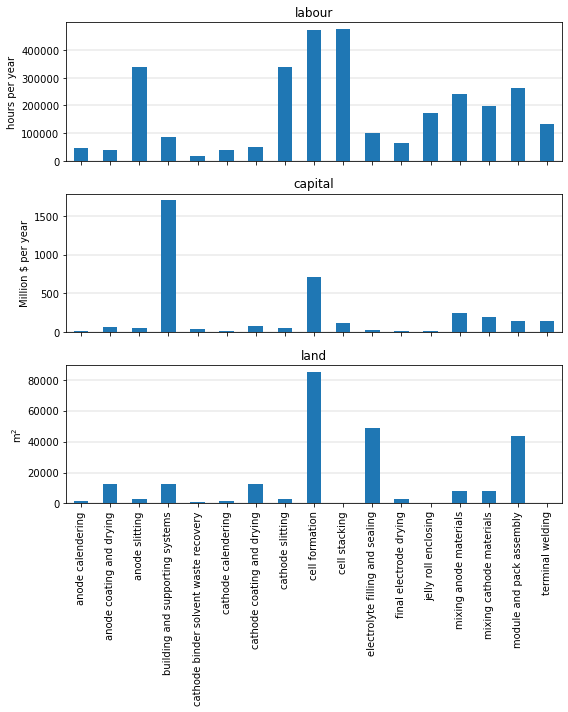

In [7]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,10))
for i, row in enumerate(F.index):
    F.loc[row].plot.bar(ax=ax[i], zorder=2)
    ax[i].set_title(row)
    ax[i].grid(lw=0.4, axis='y', zorder=0)
ax[0].set_ylabel('hours per year')
ax[1].set_ylabel('Million $ per year')
ax[2].set_ylabel(r'm$^2$')
fig.tight_layout()

The monetary $\bf{F}$ matrix ($\bf{F}_m$) can be obtained by multiplying $\bf{F}$ with the factor cost ($\mathbf{\pi}$). 

The operating expenses (e.g. R&D investments and depreciation rates) are allocated to the factor cost based on the multipliers for overhead to basic costs as used in BatPaC.




In [8]:
#Default BatPaC values (labour ($/hr), capital ($) land ($/m2)):
factor_cost          = pd.Series([25, 1000000, 3000], index=['labour', 'capital', 'land'])
factor_cost_multiplier = pd.Series(bat_cost.factor_overhead_multiplier())
#Monetary factor requirement matrix:
F_m = ((factor_cost*factor_cost_multiplier)*F.T).T


Using the same factor prices as in BatPaC, the total labour, capital and land cost are identical to the values in BatPaC, sheet 'Cost Breakdown', cell K71, K82, K93

In [9]:
F_m.sum(axis=1)/500000

labour      287.583151
capital    1845.062664
land        224.227973
dtype: float64

## Calculate material cost matrix ($\mathbf{C}$)

The material cost matrix is based on the computational structure for life cycle cost (see also [Moreau and Weidema, 2015](https://link.springer.com/article/10.1007/s11367-015-0952-1) and [Heijungs et al., 2013](https://link.springer.com/article/10.1007/s11367-012-0461-4)).


The material cost matrix, the monetary equivalent of the technology matrix ($\mathbf{A}$), is obtained by multiplying the technology matrix with the material price vector ($\mathbf{\alpha}$) 

We first obtain the cut-off foreground matrix as a Dataframe as established in the Brightway (see also LCA example notebook).

In [10]:
#Brightway2 general setup:
bw.projects.set_current('parameterised_battery_lca')
bw.bw2setup()
#Import ecoinvent 3.7.1:
if 'eidb 3.7' in bw.databases:
    pass
else:
    pathi37 = 'path to ecoinvent'
    eidb37 = bw.SingleOutputEcospold2Importer(pathi37, 'eidb 3.7')
    eidb37.apply_strategies()
    eidb37.statistics()


Biosphere database already present!!! No setup is needed


In [11]:
# First the Brightway project parameters are updated
bat_lca.update_param_battery_bw(result_dict)


# # Cut off the exchanges if activity if present in the 'cut off database'. E.g. 6um copper foil production is present in the 'cut of database' and will be cut in the anode coating process. All cut-off exchanges are set to zero
a = bat_lca.modules_with_cuts('cut_off')

In [12]:


# Divide all battery production activities by total battery system weight:
bat_product_act = [act['name'] for act in bw.Database('battery_production')]
for act in bat_product_act:
    pack_weight = result_dict['battery_pack']
    a[act]['amount'] = a[act]['amount']/pack_weight
    for exc in a[act]['cuts'].keys():
        a[act]['cuts'][exc][1] = a[act]['cuts'][exc][1]/pack_weight
        
#Cut modules:
bat_lca.cut_modules_to_zero(a)

# Establish product-module dataframe of base system
A=bat_lca.modular_technology_matrix(a)

A

,cathode current collector Al (15um) production,mixing cathode materials,busbar production,separator (11um) production,cell group interconnect production,NMC811 precursor production,coated separator (5um+2um) production,cathode current collector Al (14um) production,module interconnect panels production,jelly roll enclosing,...,market for module elastomer pads,cathode electrode scrap handling,pack terminals production,anode binder additive (SBR) production,"deep drawing, steel, 10000 kN press, single stroke",cathode current collector Al (10um) production,separator (17um) production,"market for wastewater, average",anode current collector Cu (10um) production,cell stacking
cathode current collector Al (15um),1.0,0.000000,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.000000
cathode slurry,0.0,0.443003,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.000000
busbar,0.0,0.000000,1.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.000000
separator (11um),0.0,0.000000,0.0,1,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.000000
cell group interconnect,0.0,0.000000,0.0,0,1.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cathode current collector Al (10um),0.0,0.000000,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,1.0,0,0,0.0,0.000000
separator (17um),0.0,0.000000,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,1,0,0.0,-0.008335
"wastewater, average",0.0,0.000000,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0,-1,0.0,0.000000
anode current collector Cu (10um),0.0,0.000000,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0,0,1.0,0.000000


The technology matrix can now be multiplied by the material price vector. <br>


We utilise the same calculations as in BatPaC to obtain the material cost and therefore include both prices per kg as well as the plus per unit. 

Some items are only based on a unit price (e.g. pack heating system) and others include both a mass price and unit price (e.g. row racks or the pack jacket) 

In [376]:
#import BatPaC material prices:
df_pr_mass = pd.read_excel('material_price_mass_batpac.xlsx').set_index('Goods')
df_pr_unit = pd.read_excel('material_price_unit_batpac.xlsx').set_index(['Good', 'Parameter'])
df_pr_unit = df_pr_unit['Value'].unstack().fillna(0)
dict_pr_unit = {}
for k, v in df_pr_unit.T.to_dict().items():
    dict_pr_unit[k] = {}
    for k2, v2 in v.items():
        if v2 != 0:
            dict_pr_unit[k][k2] = v2

# ADD THE ENERGY COST/OVERHEAD MULTIPLIER

In [435]:
import importlib
importlib.reload(bat_cost)

C = bat_cost.material_cost_matrix (A, df_pr_mass['Value'], dict_pr_unit,  result_dict, overhead_multiplier=None )


next we establish the scaling vector $\mathbf{s}$ using the matrix based LCI model:  

In [64]:
#Inverse the A' matrix:
A_inv = pd.DataFrame(np.linalg.pinv(A.values), A.columns, A.index)

#Establish final product demand vector for 1 battery based on pack weight
y = pd.Series(data = 0, index=A.index)
y.loc['battery pack'] = pack_weight 

#Calculate scaling vector:
s = A_inv.dot(y)

C_scaled = C*s

Now the total battery cost can be calculated:

In [65]:
F_m_pack = pd.DataFrame(columns = C.columns, index=F.index).fillna(0)
F_m_pack[F_m.columns] = (F_m/500000)

print ('Total battery material costs are: $' , round(C.dot(s).sum(), 2))
print ('Total battery factor costs are: $' , round(F_m_pack.sum(axis=1).sum(), 2))

print ('Total pack level cost: $',round(round(F_m_pack.sum(axis=1).sum(), 2)+ round(C.dot(s).sum(), 2),2))
print ('Total kWh level cost: $', round( (F_m_pack.sum(axis=1).sum() + C.dot(s).sum())/result_dict['pack_energy_kWh'], 2), 'kWh')

Total battery material costs are: $ 7381.15
Total battery factor costs are: $ 2356.87
Total pack level cost: $ 9738.02
Total kWh level cost: $ 110.76 kWh


As you can see, the kWh cost are almost identical to BatPaC. The minor difference can be explained by minor differences in terms of process yields included/excluded for cell container, cell terminals, cathode solvent and rounding of process yields

C:\Users\Joris\AppData\Local\Temp\ipykernel_2112\1952572730.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cost_results = pd.DataFrame(C_scaled.sum(axis=1).append(F_m.sum(axis=1)/500000).sort_values().tail(10), columns=['Modelled'])


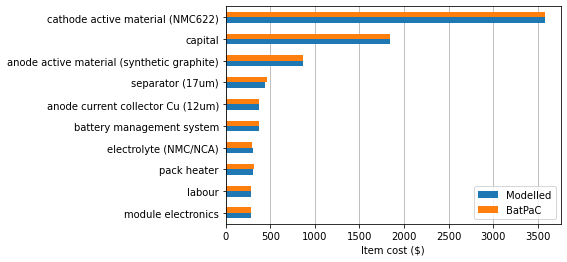

In [66]:
batpac_cost = {
    'cathode active material (NMC622)': 3578,
    'capital' :1844,
    "anode active material (synthetic graphite)": 864,
    "separator (17um)": 460,
    "anode current collector Cu (12um)": 371, 
    "battery management system":368,
    "electrolyte (NMC/NCA)": 294,
    "pack heater": 315,
    "module electronics": 282,
    "labour" : 288    
    
}

df_cost_results = pd.DataFrame(C_scaled.sum(axis=1).append(F_m.sum(axis=1)/500000).sort_values().tail(10), columns=['Modelled'])
df_batpac = pd.DataFrame.from_dict( batpac_cost, orient='index').rename(columns={0:'BatPaC'})
df_cost_results.join(df_batpac).plot.barh(zorder=2)

plt.xlabel('Item cost ($)')
plt.grid(axis='x',zorder=0)

### Impact of production scale

Text(0.5, 1.0, 'Factor cost per battery pack by battery production capacity')

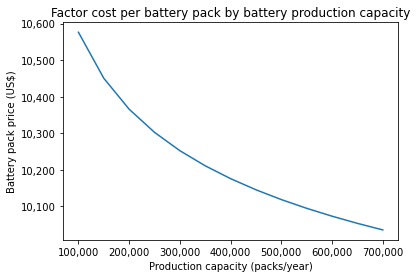

In [110]:
production = list(range(100000, 750000, 50000))
land = []
labour = []
capital = []
material = []

for x in production:
    result_dict['battery_manufacturing_capacity'] = x
    F = bat_cost.factors_battery_production(result_dict, return_aggregated=True)
    factor_cost_overhead = list(bat_cost.factor_overhead_multiplier().values())    
    a = (F.T*(factor_cost*factor_cost_overhead))
    f = a.sum()/x
    labour.append(f[0])
    capital.append(f[1])
    land.append(f[2])
    C = bat_cost.material_cost_matrix (A, df_pr_mass['Value'], dict_pr_unit,  result_dict)
    C_scaled = C*s
    material.append(C_scaled.values.sum())
    
#reset production capacity
result_dict['battery_manufacturing_capacity'] = 500000
from matplotlib.ticker import StrMethodFormatter
a = [land, labour, capital, material]
factor_cost_all = sum(map(np.array, a))
fig, ax = plt.subplots()
ax.plot(production, factor_cost_all,label='Factor costs')
plt.ylabel('Battery pack price (US$)')

plt.xlabel('Production capacity (packs/year)')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
plt.title('Factor cost per battery pack by battery production capacity')

### Impact of production location:

In [187]:


df_factor_price = pd.read_csv("factor_prices_europe.csv", index_col=0).dropna()
df_factor_price
df_cost_total = pd.DataFrame (index = ['labour', 'capital', 'land', 'material'], columns = df_factor_price.columns)


for country, factor_cost in df_factor_price.iteritems():
    F = bat_cost.factors_battery_production(result_dict, return_aggregated=True)
    factor_cost_overhead = list(bat_cost.factor_overhead_multiplier().values())    
    a = (F.T*(factor_cost*factor_cost_overhead))
    df_cost_total[country] =a.sum()/500000
    C = bat_cost.material_cost_matrix (A, df_pr_mass['Value'], dict_pr_unit,  result_dict)
    df_cost_total.loc['material', country] = (C*s).values.sum()


df_cost_total.drop('European average', axis=1, inplace=True)
index_structure= df_cost_total.sum()


Text(0.5, 0, 'Battery production location')

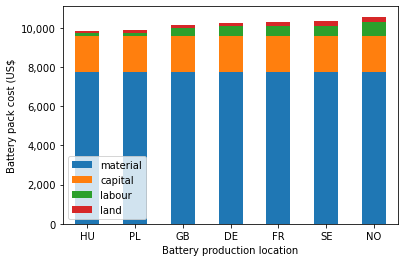

In [207]:
fig, ax = plt.subplots()

df_cost_total.sort_values(by='FR', ascending=False)[index_structure.sort_values(ascending=True).index[:]].T.plot.bar(stacked=True, rot=0, ax=ax)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
plt.ylabel('Battery pack cost (US$')
plt.xlabel('Battery production location')

### Impact of metal prices on CAM costs

To calculate the impact of fluctuating metal prices on the cathode active material (CAM) cost, we use the production cost and profit margin (PCPM) estimation of the CAM. 


In this example, we use a PCPM for NMC622 of 6.11 $/kg based on [Greenwood et al., 2020](https://www.sciencedirect.com/science/article/pii/S266624852100010X) and iterate over the cobalt, nickel, manganese and lithium prices of the last 20 years.




In [301]:
#import the metal content of the CAM
df_element_weight = pd.read_excel("elemental_weight_cam.xlsx").set_index(['Component','Element'])
df_element_weight = df_element_weight['Value'].unstack().fillna(0)
# import the historic metal prices:
df_metal_prices = pd.read_csv("historic_metal_price.csv", index_col=0)


In [441]:
# Iterate through the historic metal price data sets and multiply this by the metal content in the CAM:

historic_NMC = pd.DataFrame(index=df_metal_prices.index, columns = ['NMC622 price'])
dates = []
for date, value in df_metal_prices.iterrows():
    historic_NMC.loc[date, 'NMC622 price'] =bat_cost.cam_price(value, df_element_weight,pcpm_cam={'cathode active material (NMC622)':6.11})['cathode active material (NMC622)']
    dates.append(date)
 

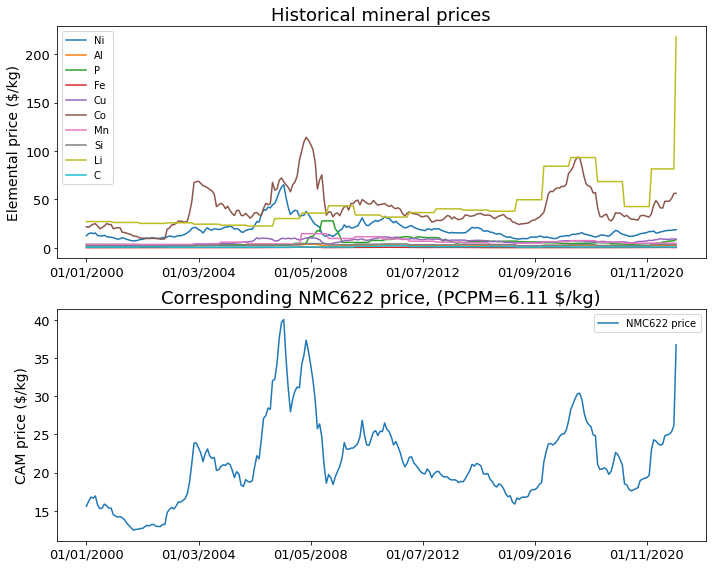

In [442]:
fig, ax = fig, ax = plt.subplots(2,1, figsize=(10,8))

df_metal_prices.plot( ax=ax[0], fontsize=13)
historic_NMC.plot(ax=ax[1], fontsize=13)

ax[0].set_ylabel('Elemental price ($/kg)', fontsize=14)
ax[1].set_ylabel('CAM price ($/kg)', fontsize=14)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_title('Historical mineral prices', fontsize=18)
ax[1].set_title('Corresponding NMC622 price, (PCPM=6.11 $/kg)', fontsize=18)
ax[1].legend()
fig.tight_layout()

Now we can calculate the corresponding battery cost by replacing the NMC622 price in the material cost price dataframe

In [443]:
historic_pack_cost = pd.DataFrame(index=df_metal_prices.index, columns = ['Pack cost'])

for date, price in historic_NMC.iterrows():
    #replace the NMC622 price
    df_pr_mass.loc['cathode active material (NMC622)', 'Value'] = price.values[0]
    C = bat_cost.material_cost_matrix (A, df_pr_mass['Value'], dict_pr_unit,  result_dict, overhead_multiplier=None )
    C_scaled = C.dot(s)
    historic_pack_cost.loc[date, 'Pack cost'] = C_scaled.values.sum()+F_m.values.sum()/500000

    

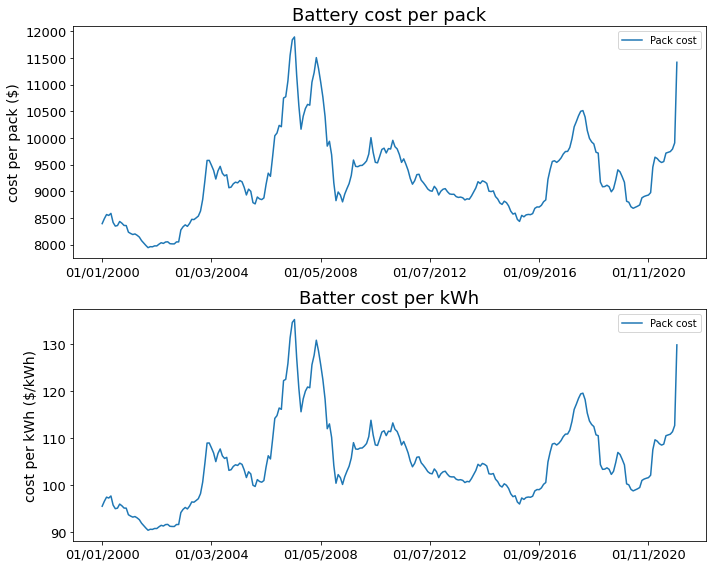

In [444]:
fig, ax = fig, ax = plt.subplots(2,1, figsize=(10,8))

historic_pack_cost.plot( ax=ax[0], fontsize=13)
(historic_pack_cost/result_dict['pack_energy_kWh']).plot(ax=ax[1], fontsize=13)
ax[0].set_ylabel('cost per pack ($)', fontsize=14)
ax[1].set_ylabel('cost per kWh ($/kWh)', fontsize=14)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_title('Battery cost per pack', fontsize=18)
ax[1].set_title('Batter cost per kWh', fontsize=18)
fig.tight_layout()

### Impact of different cathode chemistries

# Calculate the value added per process ($\pi$) 

The battery value added refers to the cost of the primary production factors, similar to the system cost of MFCA. The value added ($v$) per process is based on the rectangular choice-of-technology model (RCOT) by Duchin and Levine (2011) and the LCA extension by Katelhon et al 2016. Here value added per process is calculated with 

$$v = F'\pi$$

where $F'$ is the transpose ($'$) of the physical factor requirement matrix where rows refer to the factors and columns to the process, and $\pi$ is the price per unit factor.  <br>


## Factor requirement matrix ($F$)

In [19]:
baseline_parameters_path = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\manufacturing_cost_parameters.xlsx"
#
result_dict['design_parameters']['battery_manufacturing_capacity'] = 100000
F = bat_cost.factors_battery_production(result_dict, baseline_parameters_path, return_aggregated=True)
F

KeyError: 'design_parameters'

## Factor cost per process 
Factor cost per unit process ($b$) is calculated based on the element-wise multiplication (Hadamard product, $\circ$) of the factor requirement matrix ($F'$) and the factor price ($\pi$):
$$b=F'\circ \pi$$

In BatPaC, additional variable overhead costs (indirect cost related to materials, labour, utilities and plant maintance) and fixed expenses are included as reported in BatPaC. 
Overhead costs are here all attributed to single processes, such that $pi$ is calculated with:
$$\pi = \pi_{cost} \pi_{overhead}$$

where $\pi_{overhead}$ is the overhead multiplier. The overhead multiplier for capital ($cap$) and land ($land$) are  calculatd with:
$$\pi_{overhead} = \frac{default_{overhead} default_{capacity}}{capacity}$$

In [ ]:
# BatPaC default factor cost (land ($/m2), labour ($/hr), capital ($)):
factor_cost          = np.array([3000, 25, 1])

# factor_cost = ParameterDict['3_PR_factor_price'].Values[:,4]
result_dict['design_parameters']['battery_manufacturing_capacity'] = 100000
F = bat_cost.factors_battery_production(result_dict, baseline_parameters_path, return_aggregated=True)
F

factor_cost_overhead = list(bat_cost.factor_overhead_multiplier (100000).values())
B = (F.T*(factor_cost*factor_cost_overhead))
B.sum().astype(int)/100000


## Value added per pack and per process ($v$)

In [ ]:
b = B.T.sum(axis=0)/100000
b

In [ ]:
pack_cost_kwh = [x/60 for x in pack_cost]

plt.plot(pack_cost_kwh)

### Impact of production capacity:

### Factor cost for different countries:

In [ ]:
ParameterDict['3_PR_factor_price'].Values

production = list(range(100000, 600000, 10000))
cost_total = []

for x in range(ParameterDict['3_PR_factor_price'].Values.shape[1]):
    factor_cost = (ParameterDict['3_PR_factor_price'].Values[:,x])    
    factor_cost_overhead = list(bat_cost.factor_overhead_multiplier(100000).values())
    a = (F.T*(factor_cost*factor_cost_overhead))
    f = a.sum()/100000
    cost_total.append(f.sum())

df = pd.DataFrame(cost_total, IndexTable.loc['Regions', 'Classification'].Items,)    
    
(df.sort_values(by=0)/60).plot.bar()
plt.ylabel('US$')